# CSCI 5822 : Probabilistic Models of Human and Machine Learning
## Assignment 9
### Tarunianand Muruganandan

The software that I have decided to use is that of pyGPO, a package that was built for Python 3.5 and above, specifically for Bayesian optimization. It is a simple tool that I found online, and have used it extensivesly to accomplish tasks given in the assignment.

Note: I was going to submit a different project, but I figured that the tasks involved seemed too trivial in comparison with the given homework. I will send over my progress on that out of interest, but would like to submit this as my assignment.

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.cm import *
import numpy as np
import copy
import os
from collections import OrderedDict
%matplotlib inline

from pyGPGO.covfunc import matern52
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from pyGPGO.covfunc import rationalQuadratic


## Part 1a

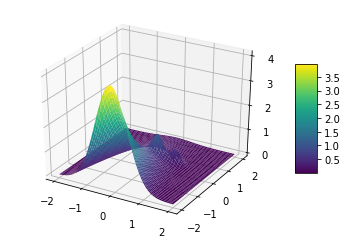

In [23]:


def base_function(x, y):
# Franke's function (https://www.mathworks.com/help/curvefit/franke.html)
    one = 0.75 * np.exp(-(9 * x - 2) ** 2 / 4 - (9 * y - 2) ** 2 / 4)
    two = 0.75 * np.exp(-(9 * x + 1) ** 2/ 49 - (9 * y + 1) / 10)
    three = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4 - (9 * y -3) ** 2 / 4)
    four = 0.25 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return one + two + three - four


def plotting_function():
    x = np.linspace(2, -2, num=1000)
    y = np.linspace(2, -2, num=1000)
    X, Y = np.meshgrid(x, y)
    Z = base_function(X, Y)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.viridis)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
plotting_function()

## Part 1b

In [24]:




def plot_f(x_values, y_values, f):
    z = np.zeros((len(x_values), len(y_values)))
    for i in range(len(x_values)):
        for j in range(len(y_values)):
            z[i, j] = f(x_values[i], y_values[j])
    plt.imshow(z.T, origin='lower', extent=[np.min(x_values), np.max(x_values), np.min(y_values), np.max(y_values)])
    plt.colorbar()
    plt.show()


def plot_convergence(model, title_text):
    sampled_values = model.history
    best_iteration = []
    for i in range(1, len(sampled_values)):
        best_sofar = max(sampled_values[0:i])
        best_iteration.append(best_sofar)
    plt.xlabel("Iterations")
    plt.ylabel("Recovered Optimum")
    plt.title(title_text)
    plt.plot(best_iteration, 'r--')


def plot_acquisition(gpgo, param, index, colors, acq_titles, new=True):
    n = 100
    r_x, r_y = gpgo.parameter_range[0], gpgo.parameter_range[1]
    x_test = np.linspace(r_x[0], r_x[1], n)
    y_test = np.linspace(r_y[0], r_y[1], n)
    z_hat = np.empty((len(x_test), len(y_test)))
    z_var = np.empty((len(x_test), len(y_test)))
    ac = np.empty((len(x_test), len(y_test)))
    for i in range(len(x_test)):
        for j in range(len(y_test)):
            res = gpgo.GP.predict([x_test[i], y_test[j]])
            z_hat[i, j] = res[0]
            z_var[i, j] = res[1][0]
            ac[i, j] = -gpgo._acqWrapper(np.atleast_1d([x_test[i], y_test[j]]))
    plt.title(acq_titles)
    plt.imshow(ac.T, origin='lower', extent=[r_x[0], r_x[1], r_y[0], r_y[1]])
    plt.colorbar()
    gpgo._optimizeAcq(method='L-BFGS-B', n_start=500)
    plt.plot(gpgo.best[0], gpgo.best[1], 'gx', markersize=15)


def plot_figure():
    x = np.linspace(-2, 2, 1000)
    y = np.linspace(-2, 2, 1000)
    plot_f(x, y, base_function)


def part_1(max_iter):
    # Plot the function
    param = OrderedDict()
    param['x'] = ('cont', [-2, 2])
    param['y'] = ('cont', [-2, 2])

    # squared exponential kernel function
    plt.suptitle("Convergence Rate, True Optimum = 0")
    np.random.seed(20)
    plt.subplot(131)
    sqexp = squaredExponential()
    gp = GaussianProcess(sqexp)
    acq = Acquisition(mode='ExpectedImprovement')
    gpgo = GPGO(gp, acq, base_function, param, n_jobs=-1)
    gpgo.run(max_iter=max_iter)
    plot_convergence(gpgo, "Squared Exponential Kernel")

    # matern52 kernel function
    np.random.seed(20)
    plt.subplot(132)
    matern = matern52()
    gp = GaussianProcess(matern)
    acq = Acquisition(mode='ExpectedImprovement')
    gpgo = GPGO(gp, acq, base_function, param, n_jobs=-1)
    gpgo.run(max_iter=max_iter)
    plot_convergence(gpgo, "Matern52 Kernel")

    # rational quadratic kernel function
    np.random.seed(20)
    plt.subplot(133)
    ratq = rationalQuadratic()
    gp = GaussianProcess(ratq)
    acq = Acquisition(mode='ExpectedImprovement')
    gpgo = GPGO(gp, acq, base_function, param, n_jobs=-1)
    gpgo.run(max_iter=max_iter)
    plot_convergence(gpgo, "Rational Quadratic Kernel")
    plt.show()


def part_2(max_iter):
    acq_1 = Acquisition(mode='ExpectedImprovement')
    acq_2 = Acquisition(mode='ProbabilityImprovement')
    acq_3 = Acquisition(mode='UCB', beta=0.5)
    acq_4 = Acquisition(mode='UCB', beta=1.5)
    acq_list = [acq_1, acq_2, acq_3, acq_4]
    sqexp = squaredExponential()
    param = OrderedDict()
    param['x'] = ('cont', [-2, 2])
    param['y'] = ('cont', [-2, 2])
    new = True
    colors = ['green', 'red', 'orange', 'black']
    acq_titles = ['Expected improvement', 'Probability of Improvement', 'GP-UCB, beta = .5',
                  'GP-UCB beta = 1.5']

    plt.suptitle('Acquisition Functions with Convergence Rates')
    idx = 0

    for index, acq in enumerate(acq_list):
        np.random.seed(200)
        gp = GaussianProcess(sqexp)
        gpgo = GPGO(gp, acq, base_function, param)
        gpgo.run(max_iter=max_iter)
        plt.subplot(4, 2, idx+1)
        plot_acquisition(gpgo, param, index + 2, colors, acq_titles[index], new=new)
        plt.subplot(4, 2, idx+2)
        plot_convergence(gpgo, acq_titles[index])
        new = False
        idx = idx + 2
    plt.show()





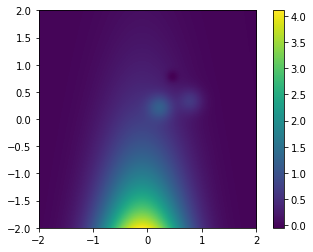

In [25]:
max_iterations = 10
plot_figure()

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.3525232  1.59085491]. 	  0.11363221748314734 	 0.11363221748314734
init   	 [1.56612292 1.26334991]. 	  0.002080916942881314 	 0.11363221748314734
init   	 [-1.85644166  0.76703033]. 	  0.002212727668146549 	 0.11363221748314734
1      	 [ 0.10188971 -0.55193766]. 	  1.0346533126427873 	 1.0346533126427873
2      	 [ 0.11862132 -1.4286939 ]. 	  2.249929407825779 	 2.249929407825779
3      	 [ 0.00670107 -1.8866476 ]. 	  3.6231969089520697 	 3.6231969089520697
4      	 [-0.22100525 -2.        ]. 	  4.024313612855641 	 4.024313612855641
5      	 [-0.3372231 -2.       ]. 	  3.7727435719310147 	 4.024313612855641
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.3525232  1.59085491]. 	  0.11363221748314734 	 0.11363221748314734
init   	 [1.56612292 1.26334991]. 	  0.002080916942881314 	 0.11363221748314734
init   	 [-1.85644166  0.76703033]. 	  0.002212727668146549 	 0.11363221748314734
1      	 [ 0.1

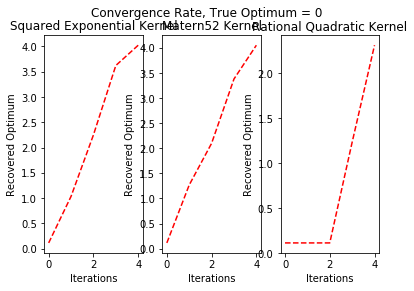

In [26]:
part_1(max_iter=5)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.79052903 -1.09381032]. 	  0.004602705466765112 	 0.5942585770310665
init   	 [ 0.37768058 -0.28676526]. 	  0.5942585770310665 	 0.5942585770310665
init   	 [ 1.05656275 -1.98855763]. 	  0.4266177961019955 	 0.5942585770310665
1      	 [-0.173693   -1.32548375]. 	  2.2228254280337776 	 2.2228254280337776
2      	 [-0.61212211 -1.51897069]. 	  1.7584861680433965 	 2.2228254280337776
3      	 [-0.02249934 -1.56461064]. 	  2.7387115891262113 	 2.7387115891262113
4      	 [-0.0475367 -1.920063 ]. 	  3.7950342619614563 	 3.7950342619614563
5      	 [-0.0926604 -2.       ]. 	  4.103150847009695 	 4.103150847009695
6      	 [-1.64820386  1.49283883]. 	  0.0035640813208187906 	 4.103150847009695
7      	 [1.83238265 1.64618494]. 	  0.00029957718133593957 	 4.103150847009695
8      	 [0.18959181 1.94070298]. 	  0.10189746024479282 	 4.103150847009695
9      	 [-1.95064876 -0.22356948]. 	  0.0030879081760374276 	 4.10315084700

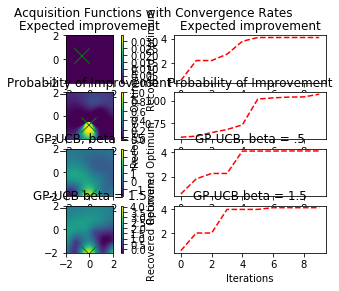

In [27]:
part_2(max_iterations)

# Part 2a

In [28]:
def generate_time_series(alpha_1, alpha_2, sigma, samples):
	mu_y1 = np.random.normal(0, sigma)
	mu_y2 = np.random.normal(0, sigma)
	mu_z = np.random.normal(0, sigma)
	y_1 = [mu_y1]*samples
	y_2 = [mu_y2]*samples
	z = [alpha_1*y_1[0] + alpha_2*y_2[0] + mu_z]*samples
	for i in range(1, samples):
		y_2[i] = y_1[i-1] + mu_y2
		y_1[i] = alpha_1*y_1[i-1] + alpha_2*y_2[i-1] + mu_y1
		z[i] = y_1[i] + mu_z
	plt.plot(z)
	plt.xlabel("Time")
	plt.ylabel("Observation")
	plt.title("Autoregressive Time Series")
	plt.show()
	return z

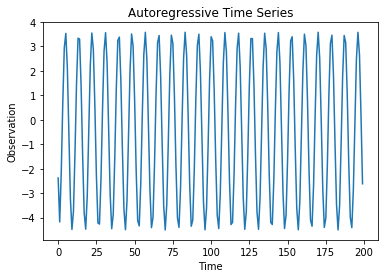

[-2.3807260415251514,
 -4.180107927392587,
 -2.2001680423415793,
 0.6493697857792182,
 2.9437366429094056,
 3.53574910048389,
 2.12940092971543,
 -0.5721337840117457,
 -3.218087683834049,
 -4.485483819840328,
 -3.7406241240274443,
 -1.355938444301839,
 1.476230379473685,
 3.3397979354113656,
 3.3029804455423624,
 1.3841866548011779,
 -1.457186541441596,
 -3.8004525450645725,
 -4.473978354256263,
 -3.141001064420823,
 -0.4680093204759723,
 2.208501005605864,
 3.550274750783768,
 2.886425042468787,
 0.5488767348184118,
 -2.29359601834217,
 -4.219756840432668,
 -4.2665253204078315,
 -2.4105172182800803,
 0.4202634148867106,
 2.810426262509146,
 3.564889900776008,
 2.306422510553866,
 -0.3357422130462102,
 -3.0405219082241817,
 -4.455526727391063,
 -3.8732542609634133,
 -1.584840742155058,
 1.2655070696298254,
 3.2526152684987957,
 3.382929755017368,
 1.591293285926255,
 -1.2264759042289861,
 -3.6614932203707347,
 -4.496250004428116,
 -3.3133678643724402,
 -0.704287870231544,
 2.0264499809

In [29]:
generate_time_series(1.5, -1, 3, 200)

# Part 2b

In [30]:

def generate_lds(alpha_1, alpha_2, sigma, samples):
	mu_y1 = np.random.normal(0, sigma)
	mu_y2 = np.random.normal(0, sigma)
	mu_z = np.random.normal(0, sigma)
	y_1 = [mu_y1]*samples
	y_2 = [mu_y2]*samples
	z = [alpha_1[0]*y_1[0] + alpha_2[0]*y_2[0] + mu_z]*samples
	alpha_mode_1 = alpha_1[0]
	alpha_mode_2 = alpha_2[0]
	mode = 0
	mode_record = [0]*samples
	for i in range(1, samples):
		if np.random.rand() < 0.3:
			draw_mode = np.random.multinomial(1, [1 / 3] * 3, size=1)
			mode = int(np.argmax(draw_mode))
			alpha_mode_1 = alpha_1[np.argmax(draw_mode)]
			alpha_mode_2 = alpha_2[np.argmax(draw_mode)]
		y_2[i] = y_1[i-1] + mu_y2
		y_1[i] = alpha_mode_1*y_1[i-1] + alpha_mode_2*y_2[i-1] + mu_y1
		z[i] = y_1[i] + mu_z
		mode_record[i] = mode
	plt.plot(z)
	plt.xlabel("Time")
	plt.ylabel("Observation")
	plt.title("Switched Linear Dynamic System with 3 modes")
	plt.show()
	return mode_record


def get_conditionals(modes):
	print("TODO")

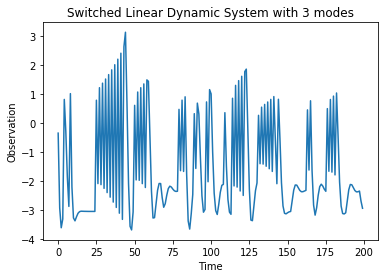

TODO


In [31]:
record = generate_lds([1, 0.7, -0.75], [-0.5, -0.2, 0.3], 2, 200)
get_conditionals(record)

# Part 2c

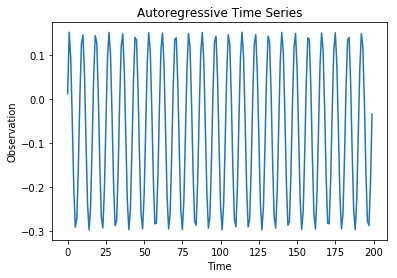

[array([0.00907707]), array([0.12512242]), array([0.1181497]), array([0.00821675]), array([-0.15747841]), array([-0.2909139]), array([-0.32691811]), array([-0.24670645]), array([-0.09067313]), array([0.06330069]), array([0.13817838]), array([0.09654488]), array([-0.04079169]), array([-0.20515889]), array([-0.31437464]), array([-0.31383032]), array([-0.20379837]), array([-0.03929463]), array([0.09742898]), array([0.13801068]), array([0.06215961]), array([-0.09219869]), array([-0.24788507]), array([-0.32705634]), array([-0.29012687]), array([-0.15556139]), array([0.00935736]), array([0.12217001]), array([0.12647022]), array([0.0201079]), array([-0.1437358]), array([-0.28313902]), array([-0.32840016]), array([-0.25688865]), array([-0.10436023]), array([0.05292087]), array([0.13631411]), array([0.10412287]), array([-0.02755723]), array([-0.19288614]), array([-0.30919941]), array([-0.3183404]), array([-0.21573861]), array([-0.05269495]), array([0.08926877]), array([0.13917067]), array([0.07

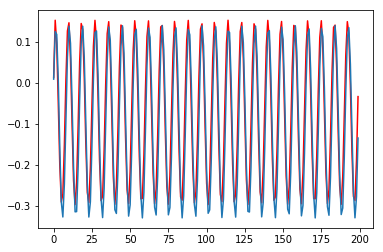

In [32]:

class KalmanFilter:
	def __init__(self, A, Q, H, R,):
		self.matrix_A = copy.deepcopy(A)
		self.matrix_H = copy.deepcopy(H)
		self.matrix_Q = copy.deepcopy(Q)
		self.matrix_R = copy.deepcopy(R)

	def predict(self, x_init, p_init):
		x_priori = np.dot(self.matrix_A, x_init)
		p_priori = np.add(np.dot(self.matrix_A, np.dot(p_init, self.matrix_A.T)), self.matrix_Q)
		return x_priori, p_priori

	def update(self, x_pri, p_pri, observation):
		innovation = observation - np.dot(self.matrix_H, x_pri)
		innovation_cov = self.matrix_R + np.dot(self.matrix_H, np.dot(p_pri, self.matrix_H.T))
		kalman_gain = np.dot(p_pri, self.matrix_H) / innovation_cov
		x_post = x_pri + np.dot(kalman_gain, innovation)
		term = np.dot(kalman_gain, self.matrix_H)
		m = 1 - term
		p_post = np.dot(m, p_pri)
		return x_post, p_post


if __name__ == '__main__':

	z = generate_time_series(1.5, -1, 0.2, 200)
	a = np.array([[1.5, -1], [-1, 0]])  # state transition matrix
	p = np.array([[0.5, 0], [0, 0.5]])  # process covariance
	q = np.array([[5, 0], [0, 5]])  # state covariance
	h = np.array([1, 0])  # observation matrix
	r = np.array([3])  # observation covariance
	kf = KalmanFilter(a, q, h, r)
	x_initial = [0, 0]
	p_initial = copy.deepcopy(p)
	z_pred = []
	for i in range(0, len(z)):
		x_in, p_in = kf.predict(x_initial, p_initial)
		x_postr, p_postr = kf.update(x_in, p_in, z[i])
		h = h.reshape(1,2)
		z_pred.append(np.dot(h, x_postr))
		x_initial = x_postr
		p_initial = p_postr
	print(z_pred)
	plt.plot(z, color='red')
	plt.plot(z_pred)
	plt.show()

